# Proyek Analisis Sentimen
## Pelatihan Dan analisis 

### import library dan dataset

In [243]:
# --- Data handling dan preprocessing ---
import pandas as pd
import numpy as np
import re
import string
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# --- NLP Bahasa Inggris ---
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- Ekstraksi Fitur ---
from sklearn.feature_extraction.text import TfidfVectorizer

# Word2Vec (menggunakan gensim)
import gensim
from gensim.models import Word2Vec

# --- Pembagian Data ---
from sklearn.model_selection import train_test_split

# --- Model ML ---
from sklearn.svm import LinearSVC # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- Evaluasi ---
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- Visualisasi (opsional, untuk hasil confusion matrix, dsb) ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [244]:
# Membaca file hasil scraping
game_df = pd.read_csv('kingdom_two_crowns_reviews.csv')

In [245]:
print(f"Jumlah Ulasan: {len(game_df)}")
print(f"Jumlah Kolom: {len(game_df.columns)}")

Jumlah Ulasan: 11054
Jumlah Kolom: 3


In [246]:
#melihat lima baris pertama dataframe
game_df.head()

,review,voted_up,timestamp
0,fun for two,True,1743779247
1,아기자기하고 재밌어요 ^^,True,1743762320
2,fun,True,1743739664
3,"I love this game, probably if not my favorite ...",True,1743708796
4,"relaxing and challenging at the same time, bea...",False,1743673434


In [247]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11054 entries, 0 to 11053
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     11009 non-null  object
 1   voted_up   11054 non-null  bool  
 2   timestamp  11054 non-null  int64 
dtypes: bool(1), int64(1), object(1)
memory usage: 183.6+ KB


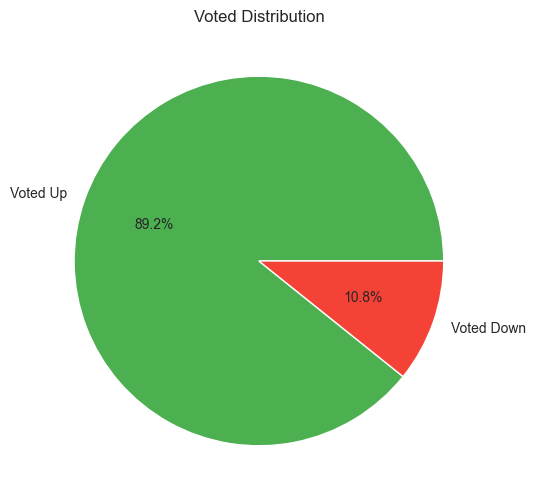

In [277]:
# Hitung jumlah voted up dan down
voted_up = game_df['voted_up'].sum()
voted_down = len(game_df) - voted_up

# Pie chart
plt.figure(figsize=(6,6))
plt.pie([voted_up, voted_down], labels=['Voted Up', 'Voted Down'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title('Voted Distribution')
plt.show()


### preprocessing

In [249]:
game_df.dropna(inplace=True)

In [250]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Tambahkan kolom baru berisi hasil deteksi bahasa
game_df['language'] = game_df['review'].apply(detect_language)

# Filter hanya yang bahasa Inggris
english_reviews = game_df[game_df['language'] == 'en'].copy()

In [251]:
english_reviews.head()

,review,voted_up,timestamp,language
0,fun for two,True,1743779247,en
3,"I love this game, probably if not my favorite ...",True,1743708796,en
4,"relaxing and challenging at the same time, bea...",False,1743673434,en
5,"Here's me playing this game: ""Wtf. What do i d...",False,1743659925,en
7,2025 coop and solo review -\r\nThis game is fa...,True,1743556897,en


In [252]:
english_reviews.shape

(8567, 4)

In [253]:
english_reviews= english_reviews.drop_duplicates()

In [254]:
english_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8567 entries, 0 to 11053
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8567 non-null   object
 1   voted_up   8567 non-null   bool  
 2   timestamp  8567 non-null   int64 
 3   language   8567 non-null   object
dtypes: bool(1), int64(1), object(2)
memory usage: 276.1+ KB


In [255]:
#inisiasi VADER
vader = SentimentIntensityAnalyzer()

In [256]:
#pelabelan berdasarkan skor compound
def get_sentiment(text):
    score = vader.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [257]:
english_reviews['sentiment'] = english_reviews['review'].apply(get_sentiment)

In [258]:
english_reviews.head()

,review,voted_up,timestamp,language,sentiment
0,fun for two,True,1743779247,en,positive
3,"I love this game, probably if not my favorite ...",True,1743708796,en,positive
4,"relaxing and challenging at the same time, bea...",False,1743673434,en,positive
5,"Here's me playing this game: ""Wtf. What do i d...",False,1743659925,en,positive
7,2025 coop and solo review -\r\nThis game is fa...,True,1743556897,en,positive


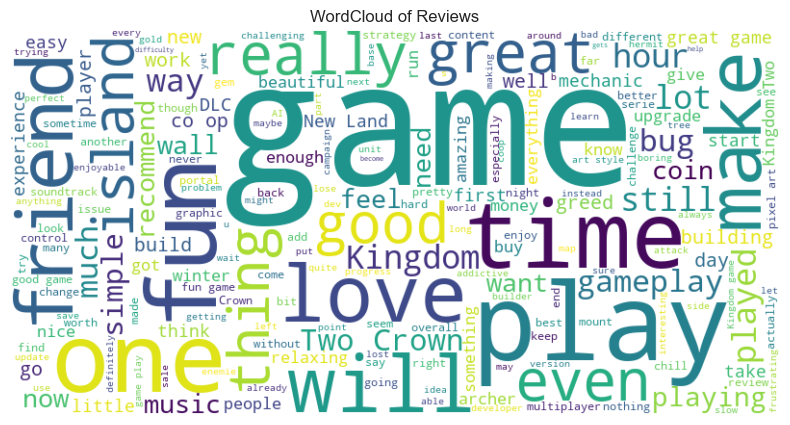

In [259]:
all_text = ' '.join(english_reviews['review'])

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Reviews')
plt.show()


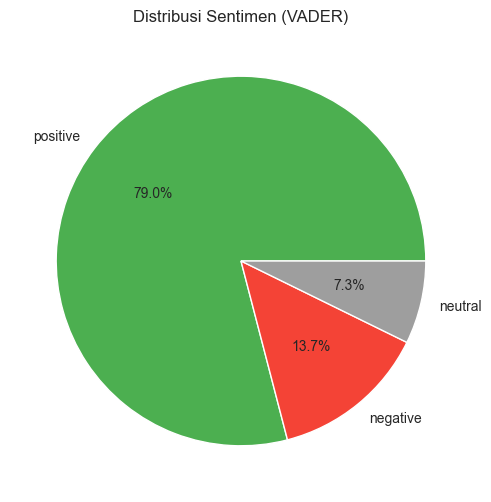

In [260]:
sentiment_counts = english_reviews['sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=['#4CAF50', '#F44336', '#9E9E9E'] 
)
plt.title('Distribusi Sentimen (VADER)')
plt.ylabel('')
plt.show()


In [261]:
#memfilter untuk memastikan review hanya terdiri sentimen positif dan negatif
filtered_df = english_reviews[english_reviews['sentiment'].isin(['positive', 'negative'])]

In [262]:
#inisiaasi
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def cleaningText(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # menghapus mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # menghapus hashtags
    text = re.sub(r'RT[\s]', '', text)         # menghapus RT
    text = re.sub(r"http\S+", '', text)        # menghapus URLs
    text = re.sub(r'[0-9]+', '', text)         # menghapus numbers
    text = re.sub(r'[^\w\s]', '', text)        # menghapus punctuation
    
    text = text.replace('\n',' ')
    text = text.strip()
    return text
def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(tokens):
    return [word for word in tokens if word not in stopwords]

def lemmatizingText(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

def toSentence(tokens):
    return ' '.join(tokens)

In [263]:
slangwords_en = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "lol": "laughing out loud",
    "omg": "oh my god",
    "idk": "i don't know",
    "btw": "by the way",
    "imo": "in my opinion",
    "brb": "be right back",
    "wtf": "what the heck",
    "lmao": "laughing my ass off",
    "thx": "thanks",
    "pls": "please",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "ain't": "is not"
}

def fix_slangwords_en(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords_en:
            fixed_words.append(slangwords_en[word.lower()])
        else:
            fixed_words.append(word)

    return ' '.join(fixed_words)


In [264]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
filtered_df['text_clean'] =filtered_df['review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefolding'
filtered_df['text_casefolding'] = filtered_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang Inggris dengan kata-kata standar dan menyimpannya di 'text_slangwords'
filtered_df['text_slangwords'] = filtered_df['text_casefolding'].apply(fix_slangwords_en)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizing'
filtered_df['text_tokenizing'] = filtered_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stopwords (baik bahasa Inggris dan lainnya jika perlu) lalu simpan di 'text_stopword'
filtered_df['text_stopword'] = filtered_df['text_tokenizing'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat akhir dan menyimpannya di 'text_final'
filtered_df['text_final'] = filtered_df['text_stopword'].apply(toSentence)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13800\2822147552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text_clean'] =filtered_df['review'].apply(cleaningText)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13800\2822147552.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text_casefolding'] = filtered_df['text_clean'].apply(casefoldingText)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13800\2822147552.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [265]:
filtered_df.head()

,review,voted_up,timestamp,language,sentiment,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopword,text_final
0,fun for two,True,1743779247,en,positive,fun for two,fun for two,fun for two,"[fun, for, two]","[fun, two]",fun two
3,"I love this game, probably if not my favorite ...",True,1743708796,en,positive,I love this game probably if not my favorite i...,i love this game probably if not my favorite i...,i love this game probably if not my favorite i...,"[i, love, this, game, probably, if, not, my, f...","[love, game, probably, favorite, top, favorite...",love game probably favorite top favorite games...
4,"relaxing and challenging at the same time, bea...",False,1743673434,en,positive,relaxing and challenging at the same time beau...,relaxing and challenging at the same time beau...,relaxing and challenging at the same time beau...,"[relaxing, and, challenging, at, the, same, ti...","[relaxing, challenging, time, beautiful, artwork]",relaxing challenging time beautiful artwork
5,"Here's me playing this game: ""Wtf. What do i d...",False,1743659925,en,positive,Heres me playing this game Wtf What do i do I ...,heres me playing this game wtf what do i do i ...,heres me playing this game what the heck what ...,"[heres, me, playing, this, game, what, the, he...","[heres, playing, game, heck, dont, get, works,...",heres playing game heck dont get works isnt au...
7,2025 coop and solo review -\r\nThis game is fa...,True,1743556897,en,positive,coop and solo review \r This game is fantastic...,coop and solo review \r this game is fantastic...,coop and solo review this game is fantastic re...,"[coop, and, solo, review, this, game, is, fant...","[coop, solo, review, game, fantastic, really, ...",coop solo review game fantastic really good no...


pembagian fitur

In [266]:
#mapping fitur
label_map = {'positive': 1, 'negative': 0}

## Training 1

Algoritma: **SVM**
Ekstraksi Fitur : **TF-IDF**
**Split 80/20**

In [267]:
#Mulai dengan membagi 
X = filtered_df['text_final']
y = filtered_df['sentiment'].map(label_map)
vect_pertama = TfidfVectorizer()
X_tfidf = vect_pertama.fit_transform(X)
#split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [268]:
# Training model SVM
svm_first_model = LinearSVC(class_weight='balanced')
svm_first_model.fit(X_train, y_train)

# Evaluasi
y_pred_train_pertama = svm_first_model.predict(X_train)
y_pred_test_pertama = svm_first_model.predict(X_test)

# Evaluasi akurasi
accuracy_train_svm = accuracy_score(y_train, y_pred_train_pertama)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_pertama)

# Menampilkan hasil
print("First Training- Accuracy (Train):", accuracy_train_svm)
print("First Training - Accuracy (Test):", accuracy_test_svm)
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test_pertama))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test_pertama))

First Training- Accuracy (Train): 0.987728130899937
First Training - Accuracy (Test): 0.8930144745122719

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.62      0.67      0.64       231
           1       0.94      0.93      0.94      1358

    accuracy                           0.89      1589
   macro avg       0.78      0.80      0.79      1589
weighted avg       0.90      0.89      0.89      1589

Confusion Matrix (Test):
 [[ 154   77]
 [  93 1265]]


## Training 2

Algoritma: **Random Forest**
Ekstraksi Fitur : **Word2Vec**
**Split 80/20**

In [269]:
tokenized_reviews = filtered_df['text_stopword']

#melatih model
# Latih Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

# Fungsi untuk mengubah satu review menjadi rata-rata vector
def get_vector(tokens):
    valid_vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if valid_vecs:
        return np.mean(valid_vecs, axis=0)
    else:
        return np.zeros(100)  # fallback apabila semua token tidak ditemukan

# Apply ke semua review
X_w2v = np.array([get_vector(tokens) for tokens in tokenized_reviews])
y = filtered_df['sentiment'].map(label_map)

In [270]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = rf_model.predict(X_test)
y_pred_train_kedua = rf_model.predict(X_train)
y_pred_test_kedua = rf_model.predict(X_test)


# Evaluasi akurasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_kedua)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_kedua)

# Menampilkan hasil
print("Second Training- Accuracy (Train):", accuracy_train_rf)
print("Second - Accuracy (Test):", accuracy_test_rf)
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test_kedua))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test_kedua))

Second Training- Accuracy (Train): 0.999685336689742
Second - Accuracy (Test): 0.8703587161736942

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.60      0.32      0.42       231
           1       0.89      0.96      0.93      1358

    accuracy                           0.87      1589
   macro avg       0.75      0.64      0.67      1589
weighted avg       0.85      0.87      0.85      1589

Confusion Matrix (Test):
 [[  75  156]
 [  50 1308]]


## Training 3

Algoritma: **SVM**
Ekstraksi Fitur : **TF-IDF**
**Split 70/30**

In [271]:
# TF-IDF vectorization
vect_ketiga = TfidfVectorizer()
X = vect_ketiga.fit_transform(filtered_df['text_final'])
y = filtered_df['sentiment'].map(label_map)

# Split 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [272]:
# Model training dengan SVM
svm_second_model = LinearSVC(class_weight='balanced')
svm_second_model.fit(X_train, y_train)

# Prediksi untuk data training dan testing
y_pred_train_ketiga = svm_second_model.predict(X_train)
y_pred_test_ketiga  = svm_second_model.predict(X_test)

# Evaluasi akurasi
accuracy_train = accuracy_score(y_train, y_pred_train_ketiga)
accuracy_test = accuracy_score(y_test, y_pred_test_ketiga)

# Menampilkan hasil evaluasi
print("Third Training - Accuracy (Train):", accuracy_train)
print("Third Training - Accuracy (Test):", accuracy_test)

print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test_ketiga))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test_ketiga))

Third Training - Accuracy (Train): 0.9906491638194569
Third Training - Accuracy (Test): 0.886744966442953

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.60      0.63      0.61       342
           1       0.94      0.93      0.93      2042

    accuracy                           0.89      2384
   macro avg       0.77      0.78      0.77      2384
weighted avg       0.89      0.89      0.89      2384

Confusion Matrix (Test):
 [[ 214  128]
 [ 142 1900]]


Berdasarkan hasil tiga percobaan:

- Percobaan pertama memberikan hasil terbaik secara keseluruhan dengan akurasi sebesar 89.04%. Model mampu mengenali sentimen positif maupun negatif secara cukup seimbang, dengan f1-score kelas negatif mencapai 0.66 dan kelas positif 0.93.

- Percobaan kedua menghasilkan akurasi 87.84%, yang merupakan hasil terendah dari ketiganya. Meskipun performa untuk sentimen positif sangat baik (recall 0.97), model masih kurang andal dalam mengidentifikasi sentimen negatif, dengan f1-score hanya 0.46 untuk kelas negatif.

- Percobaan ketiga menghasilkan akurasi 88.67%, sedikit lebih tinggi dari percobaan kedua. 

## Inference 

In [273]:
new_reviews = [
     "This game is absolutely amazing. The graphics and gameplay are top-notch!",
    "Very buggy and crashes all the time. not recommended.",
    "It's okay, but it could be better with updates."
]

In [275]:
def preprocess_text(text):
    cleaned = cleaningText(text)
    lowercased = casefoldingText(cleaned)
    tokenized = tokenizingText(lowercased)
    filtered = filteringText(tokenized)
    lemmatized = lemmatizingText(filtered)
    final_text = toSentence(lemmatized)
    return final_text

preprocessed_reviews = [preprocess_text(text) for text in new_reviews]

# TF-IDF transform
tfidf_reviews = vect_pertama.transform(preprocessed_reviews)

# Prediksi
predictions = svm_first_model.predict(tfidf_reviews)

for review, label in zip(new_reviews, predictions):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: This game is absolutely amazing. The graphics and gameplay are top-notch!
Predicted Sentiment: Positive

Review: Very buggy and crashes all the time. not recommended.
Predicted Sentiment: Negative

Review: It's okay, but it could be better with updates.
Predicted Sentiment: Positive


Dalam proyek analisis ini terlihat denagan jelas model terlalu agresif dalam menebak kelas positif dimana hal ini kurang bagus dan tidak direkomendasi untuk menganalisis sebuah sentimen yang dimana diperlukan untuk pengembangan lebih lanjut. Hal ini juga disebabkan memang adanya imbalance data pada sumbernya dimana game ini sendiri memang memiliki rated Very positive dimaana artinya game ini memilii review yang bagus